In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.decomposition import PCA 
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier, train
# from xgboost.sklearn import XGBClassifier
# Regression Metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
# subsample
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import BorderlineSMOTE
# clustering
from sklearn.cluster import AgglomerativeClustering 
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
# Classification metrics
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import cohen_kappa_score
# Ignore ConvergenceWarning messages
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
train = pd.read_csv('train.csv')
train_ft = pd.read_csv('train_ft.csv')
cnn_features = pd.read_csv('100_feature.csv')

In [ ]:
col_to_use = train_ft.columns.difference(train.columns)
col_to_use = col_to_use.tolist()
col_to_use.append('SK_ID_CURR')
train = train.merge(train_ft[col_to_use], on='SK_ID_CURR', how='right')

In [ ]:
train = pd.concat([train, cnn_features ], axis=1, sort=False)
train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE_x,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,bfeat_61,bfeat_62,bfeat_63,bfeat_64,bfeat_65,bfeat_66,bfeat_67,bfeat_68,bfeat_69,bfeat_70,bfeat_71,bfeat_72,bfeat_73,bfeat_74,bfeat_75,bfeat_76,bfeat_77,bfeat_78,bfeat_79,bfeat_80,bfeat_81,bfeat_82,bfeat_83,bfeat_84,bfeat_85,bfeat_86,bfeat_87,bfeat_88,bfeat_89,bfeat_90,bfeat_91,bfeat_92,bfeat_93,bfeat_94,bfeat_95,bfeat_96,bfeat_97,bfeat_98,bfeat_99,bfeat_100
0,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003542,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,...,0.000000,2.005086,0.421874,1.197328,0.531793,0.945790,0.000000,1.559564,0.000000,0.000000,1.519931,1.324294,0.141477,0.453645,0.623417,0.203760,0.529609,0.871859,1.856091,0.000000,1.120156,0.652034,0.919490,0.000000,0.527094,0.053069,0.268423,0.431745,0.000000,1.406929,1.805967,0.921971,1.314763,0.000000,0.000000,0.893562,0.402721,0.509323,0.000000,2.026018
1,100034,0,Revolving loans,M,N,Y,0,90000.0,180000.0,9000.0,180000.0,Unaccompanied,Working,Higher education,Single / not married,With parents,0.030760,-10341,-1010,-4800.0,-3015,NaN,1,1,0,1,0,0,Laborers,1.0,2,2,TUESDAY,16,0,0,0,0,0,0,...,2.176697,0.000000,0.000000,0.000000,0.000000,0.000000,1.378044,0.000000,0.000000,0.831033,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.516575,0.000000,0.000000,0.000000,0.000000,0.000000,2.054308,0.000000,0.000000,0.000000,1.858672,0.000000
2,100041,0,Cash loans,F,N,N,0,112500.0,450000.0,44509.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.008575,-12158,-1275,-6264.0,-2009,NaN,1,1,1,1,1,0,Sales staff,2.0,2,2,MONDAY,19,0,0,0,0,0,0,...,2.176697,0.000000,0.000000,0.000000,0.000000,0.000000,1.378044,0.000000,0.000000,0.831033,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.516575,0.000000,0.000000,0.000000,0.000000,0.000000,2.054308,0.000000,0.000000,0.000000,1.858672,0.000000
3,100045,0,Cash loans,F,N,Y,0,99000.0,247275.0,17338.5,225000.0,Unaccompanied,Pensioner,Secondary / secondary special,Married,House / apartment,0.006207,-23920,365243,-9816.0,-4969,NaN,1,0,0,1,1,0,NaN,2.0,2,2,FRIDAY,11,0,0,0,0,0,0,...,2.176697,0.000000,0.000000,0.000000,0.000000,0.000000,1.378044,0.000000,0.000000,0.831033,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.516575,0.000000,0.000000,0.000000,0.000000,0.000000,2.054308,0.000000,0.000000,0.000000,1.858672,0.000000
4,100058,0,Revolving loans,F,N,Y,0,54000.0,135000.0,6750.0,135000.0,Unaccompanied,State servant,Higher education,Married,House / apartment,0.014520,-12406,-1176,-1149.0,-2576,NaN,1,1,0,0,0,0,Core staff,2.0,2,2,THURSDAY,9,0,0,0,0,0,0,...,0.000000,1.936642,0.000000,0.723456,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.128522,3.066451,1.613078,2.911247,2.819230,0.000000,0.000000,1.457821,3.728114,1.814632,2.643413,0.000000,0.000000,2.481227,0.000000,0.000000,0.000000,0.307315,0.000000,3.241490,0.154884,1.751562,3.570715,2.487453,0.000000,0.502090,2.42

In [ ]:
# train = reduce_mem_usage(train)
# train = train.sample(frac=1)
# train = train[:30000]

In [ ]:
corr = train.corr()
corr

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,...,bfeat_61,bfeat_62,bfeat_63,bfeat_64,bfeat_65,bfeat_66,bfeat_67,bfeat_68,bfeat_69,bfeat_70,bfeat_71,bfeat_72,bfeat_73,bfeat_74,bfeat_75,bfeat_76,bfeat_77,bfeat_78,bfeat_79,bfeat_80,bfeat_81,bfeat_82,bfeat_83,bfeat_84,bfeat_85,bfeat_86,bfeat_87,bfeat_88,bfeat_89,bfeat_90,bfeat_91,bfeat_92,bfeat_93,bfeat_94,bfeat_95,bfeat_96,bfeat_97,bfeat_98,bfeat_99,bfeat_100
SK_ID_CURR,1.000000,0.002456,-0.007622,0.003178,-0.001299,-0.003913,-0.001103,-0.004204,0.006888,-0.004011,0.012160,0.006619,0.016653,NaN,0.003772,0.004274,0.004877,-0.002526,0.001265,-0.010411,0.003886,0.001092,0.002999,-0.004957,-0.007084,-0.004384,-0.005260,-0.001451,-0.000391,-0.018579,-0.001757,-0.004286,0.003202,0.000783,-0.002977,0.008557,-0.005226,-0.000747,0.000446,-0.000565,...,0.003077,-0.005501,0.002089,0.000377,0.001386,0.001667,0.002763,0.001672,0.001256,0.001561,-0.003232,-0.006780,-0.005217,-0.006041,-0.005844,0.001300,0.001786,-0.001246,-0.006222,-0.005100,-0.005968,0.001878,0.001997,-0.005605,0.001919,0.001610,0.001110,0.001017,0.002700,-0.005580,0.001748,-0.002202,-0.006004,-0.006134,0.002628,0.001036,-0.005903,0.001711,0.002994,-0.006370
TARGET,0.002456,1.000000,0.012318,-0.017667,-0.025190,-0.016093,-0.033624,-0.037446,0.075830,-0.040119,0.041950,0.052314,0.034422,NaN,0.041245,0.014991,0.012634,-0.017517,0.008694,0.003660,0.043800,0.044958,-0.023057,-0.003249,0.001818,0.002369,0.012194,0.016311,0.013032,-0.153665,-0.147321,-0.180239,-0.030061,-0.027218,-0.011856,-0.025979,-0.021904,-0.039551,-0.020288,-0.046004,...,0.019859,-0.041181,-0.016924,-0.019622,-0.015837,-0.023723,0.017861,-0.016939,-0.017278,-0.007534,-0.035400,-0.034995,-0.036069,-0.035911,-0.028851,-0.014976,-0.015825,-0.025714,-0.010163,-0.029769,-0.028018,-0.015396,-0.017940,-0.021652,-0.016282,-0.015786,-0.014959,-0.013503,0.016723,-0.023638,-0.016651,-0.021668,-0.015922,-0.023935,0.016036,-0.015026,-0.035640,-0.017816,0.018617,-0.026559
CNT_CHILDREN,-0.007622,0.012318,1.000000,0.047158,0.017971,0.032124,0.013992,-0.020910,0.332930,-0.238762,0.185961,-0.020198,-0.007904,NaN,0.239870,0.035168,0.003991,-0.027221,0.028510,0.863405,0.013176,0.014746,0.009480,-0.021948,0.014785,0.021352,0.003430,0.045842,0.049381,-0.130428,-0.010030,-0.045763,-0.015303,-0.008916,0.018201,0.034831,0.006108,-0.009149,-0.005703,-0.010875,...,-0.009431,-0.032283,0.037907,0.039926,0.037217,0.032184,-0.009271,0.037812,0.026990,0.030992,0.013802,-0.033389,-0.033683,-0.031669,-0.033009,0.034545,0.039737,0.034248,-0.021399,-0.032646,-0.033181,0.038962,0.036946,-0.031659,0.032100,0.035439,0.038034,0.040944,-0.009286,-0.032021,0.041714,0.028342,-0.028439,-0.032736,-0.009623,0.042840,-0.014793,0.032727,-0.009628,-0.029338
AMT_INCOME_TOTAL,0.003178,-0.017667,0.047158,1.000000,0.358797,0.442475,0.364127,0.211245,0.073790,-0.155120,0.069773,0.025936,-0.119962,NaN,0.154705,-0.004624,-0.032075,0.012578,0.097394,0.062406,-0.231123,-0.250470,0.066617,0.070324,0.144340,0.131613,0.026662,0.054423,0.051546,0.091025,0.140567,-0.060262,0.108567,0.066862,0.012795,0.042757,0.093658,0.143216,0.023127,0.175144,...,-0.067684,-0.060434,0.171852,0.199447,0.172708,0.163098,-0.063333,0.178883,0.125885,0.140833,0.112888,-0.081129,-0.102405,-0.087930,-0.103429,0.157266,0.184645,0.178571,-0.031601,-0.109123,-0.091041,0.178524,0.170569,-0.112445,0.145751,0.160633,0.174500,0.

In [ ]:
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.98)]
to_drop

['AMT_GOODS_PRICE',
 'YEARS_BUILD_MODE',
 'FLOORSMAX_MODE',
 'FLOORSMIN_MODE',
 'APARTMENTS_MEDI',
 'BASEMENTAREA_MEDI',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'YEARS_BUILD_MEDI',
 'COMMONAREA_MEDI',
 'ELEVATORS_MEDI',
 'ENTRANCES_MEDI',
 'FLOORSMAX_MEDI',
 'FLOORSMIN_MEDI',
 'LANDAREA_MEDI',
 'LIVINGAPARTMENTS_MEDI',
 'LIVINGAREA_MEDI',
 'NONLIVINGAPARTMENTS_MEDI',
 'NONLIVINGAREA_MEDI',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'MAX(bureau.DAYS_CREDIT)',
 'MAX(bureau.MIN(bureaubal.MONTHS_BALANCE))',
 'MAX(bureau.STD(bureaubal.MONTHS_BALANCE))',
 'MAX(bureaubal.bureau.AMT_ANNUITY)',
 'MAX(bureaubal.bureau.AMT_CREDIT_MAX_OVERDUE)',
 'MAX(bureaubal.bureau.AMT_CREDIT_SUM)',
 'MAX(bureaubal.bureau.AMT_CREDIT_SUM_DEBT)',
 'MAX(bureaubal.bureau.AMT_CREDIT_SUM_LIMIT)',
 'MAX(bureaubal.bureau.AMT_CREDIT_SUM_OVERDUE)',
 'MAX(bureaubal.bureau.CNT_CREDIT_PROLONG)',
 'MAX(bureaubal.bureau.CREDIT_DAY_OVERDUE)',
 'MAX(bureaubal.bureau.DAYS_CREDIT)',
 'MAX(bureaubal.bureau.DAYS_CREDIT_ENDDATE)',
 'MAX(bureaubal.bure

In [ ]:
train = train.drop(to_drop, axis=1)

In [ ]:
train.describe() #outlier: max(days_Employed)
outlier = train[train['DAYS_EMPLOYED'] == 365243]
outlier['TARGET'].value_counts()/len(outlier)
train['DAYS_EMPLOYED'].describe()
train['TARGET'].value_counts()/len(train) # Outlier had lower rate of default (target = 1)

0    0.9295
1    0.0705
Name: TARGET, dtype: float64

In [ ]:
# train['Days_employed_outlier'] = train['DAYS_EMPLOYED'] == 365243
train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True) # replace outlier by 
train['DAYS_EMPLOYED'].fillna(np.mean(train['DAYS_EMPLOYED']), inplace= True) # fill na with by mean of the column

In [ ]:
# Feature engineering
train['Credit_income_ratio'] = train['AMT_CREDIT']/train['AMT_INCOME_TOTAL']
train['Anuity_income_ratio'] = train['AMT_ANNUITY']/train['AMT_INCOME_TOTAL'] 
train['Credit_term'] = train['AMT_ANNUITY']/train['AMT_CREDIT'] #length of the payment in months since the annuity is the monthly amount due
train['Days_employed_age'] = train['DAYS_EMPLOYED']/train['DAYS_BIRTH']

In [ ]:
corr = train.corr()['TARGET'].sort_values()
corr.head(10)

STD(prev.NUM_UNIQUE(ccb.NAME_CONTRACT_STATUS))   -0.251259
EXT_SOURCE_3                                     -0.180239
EXT_SOURCE_1                                     -0.153665
EXT_SOURCE_2                                     -0.147321
MAX(ccb.prev.DAYS_FIRST_DRAWING)                 -0.086485
MAX(ccb.prev.DAYS_FIRST_DUE)                     -0.080516
STD(prev.MEAN(ccb.MONTHS_BALANCE))               -0.078805
MAX(ccb.prev.AMT_DOWN_PAYMENT)                   -0.073551
STD(prev.MIN(ccb.CNT_INSTALMENT_MATURE_CUM))     -0.069815
SKEW(prev.DAYS_FIRST_DRAWING)                    -0.067258
Name: TARGET, dtype: float64

In [ ]:
corr.dropna().tail(10)

MEAN(bureaubal.bureau.DAYS_CREDIT)             0.074201
DAYS_CREDIT3                                   0.074570
DAYS_BIRTH                                     0.075830
MEAN(bureau.DAYS_CREDIT)                       0.077618
MAX(prev.MEAN(ccb.AMT_INST_MIN_REGULARITY))    0.078396
STD(prev.DAYS_FIRST_DRAWING)                   0.080523
MAX(prev.MEAN(ccb.AMT_BALANCE))                0.085448
MAX(pc.prev.RATE_INTEREST_PRIVILEGED)          0.163496
STD(prev.MAX(ccb.AMT_CREDIT_LIMIT_ACTUAL))     0.178770
TARGET                                         1.000000
Name: TARGET, dtype: float64

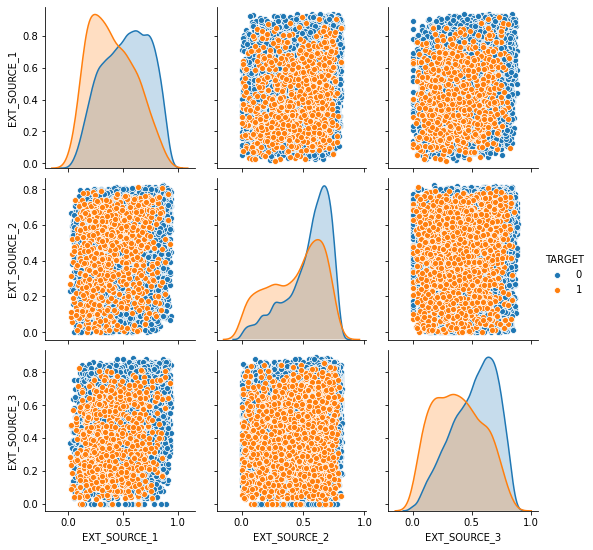

In [ ]:
cols = ['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']
sns.pairplot(train[cols][:30000], height = 2.5, hue='TARGET')
plt.show()

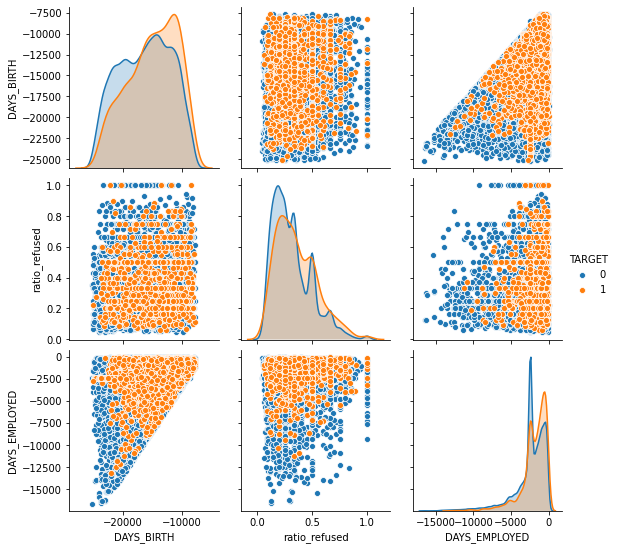

In [ ]:
cols = ['TARGET','DAYS_BIRTH', 'ratio_refused', 'DAYS_EMPLOYED']
sns.pairplot(train[cols][:30000], height = 2.5, hue= 'TARGET')
plt.show()

In [ ]:
# train['TARGET'].value_counts()/len(train)

In [ ]:
y = train['TARGET']
X = train.drop('TARGET', axis=1)

In [ ]:
# # LightGBM offers good accuracy with integer-encoded categorical features. 
from sklearn.preprocessing import LabelEncoder
class_le = LabelEncoder()
cols = X.select_dtypes(include= object).columns
for col in cols:
    X[col] = class_le.fit_transform(X[col].values.astype(str))
    X[col] = X[col].astype('category')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size = 0.2, random_state=1234)
pipeline = make_pipeline(StandardScaler(), LGBMClassifier()) # PCA(n_components = 175)
params = {
    'lgbmclassifier__num_leaves' : [100], # value < 2^max depth theoritically default is 100
     # 'lgbmclassifier__min_data_in_leaf': [100], #default is 20 is used to prevent
    'lgbmclassifier__learning_rate': [0.05], #[0.01, 0.05, 0.1], 0.1
     # 'lgbmclassifier__max_depth' : [3, 5, 7]
}
model = RandomizedSearchCV(pipeline, params, n_iter=1,  scoring='roc_auc', cv=5, n_jobs=-1, verbose = 3)
model.fit(X_train, y_train)
model.best_score_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  7.3min finished
/usr/local/lib/python3.6/dist-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.6/dist-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)


0.7373882279341178

In [ ]:
model.best_params_

{'lgbmclassifier__learning_rate': 0.05, 'lgbmclassifier__num_leaves': 100}

In [ ]:
from sklearn.metrics import accuracy_score
pred = model.predict_proba(X_test)
pred = [p[1] for p in pred] 
print('LGBoost AUC', roc_auc_score(y_test, pred))
pred_class = model.predict(X_test)

LGBoost AUC 0.7522940179748114


In [ ]:
# Class Probabilities
pred = model.predict_proba(X_test)
pred = [p[1] for p in pred] # Positive class (1) probabilities

In [ ]:
# Import confusion_matrix
from sklearn.metrics import confusion_matrix
# print( confusion_matrix(y_test, pred_class) )
# cm = confusion_matrix(y_test, pred_class)
pred_class_2 = (np.array(pred) > 0.1).astype(int)
print(confusion_matrix(y_test, pred_class_2))
cm = confusion_matrix(y_test, pred_class_2)
# True Positives (TP)
tp = cm[1][1]
# False Positives (FP)
fp = cm[0][1]
# True Negatives (TN)
tn = cm[0][0]
# False Negatives (FN)
fn = cm[1][0]
precision = tp / (tp + fp)
print( 'Precision:', precision )
recall = tp / (tp + fn)
print( 'Recall', recall )

[[5066  479]
 [ 308  147]]
Precision: 0.23482428115015974
Recall 0.3230769230769231


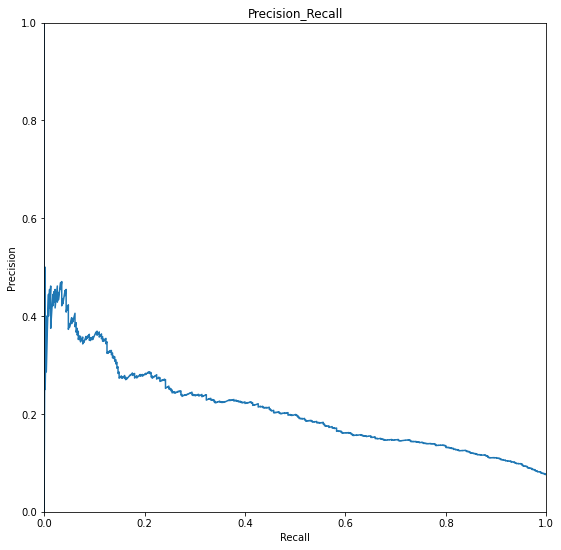

In [ ]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, pred)
# pd.DataFrame({'precision': precision, 'recall' : recall})
# Initialize figure
fig = plt.figure(figsize=(9,9))
plt.title('Precision_Recall')

# Plot Precision-Recall curve
plt.plot(recall, precision)

# Axes limits and labels
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [ ]:
# Calculate ROC curve from y and pred
fpr, tpr, thresholds = roc_curve(y_test, pred)
f1score = 2*(tpr+fpr)/(tpr*fpr)
precision = tpr / (tpr + fpr)
recall = tpr
pd.DataFrame({'Precision': precision, 'Recall' : tpr, 'F1SCORE': f1score, 'Thresholds' : thresholds})

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


,Precision,Recall,F1SCORE,Thresholds
0,NaN,0.000000,NaN,1.689478
1,0.000000,0.000000,inf,0.689478
2,0.924167,0.002198,1.200000e+04,0.597422
3,0.802460,0.002198,4.606667e+03,0.549520
4,0.890405,0.004396,4.151667e+03,0.525857
...,...,...,...,...
781,0.506218,0.995604,4.068254e+00,0.006186
782,0.506769,0.997802,4.063830e+00,0.006184
783,0.501260,0.997802,4.018938e+00,0.004956
784,0.501810,1.000000,4.014532e+00,0.004932


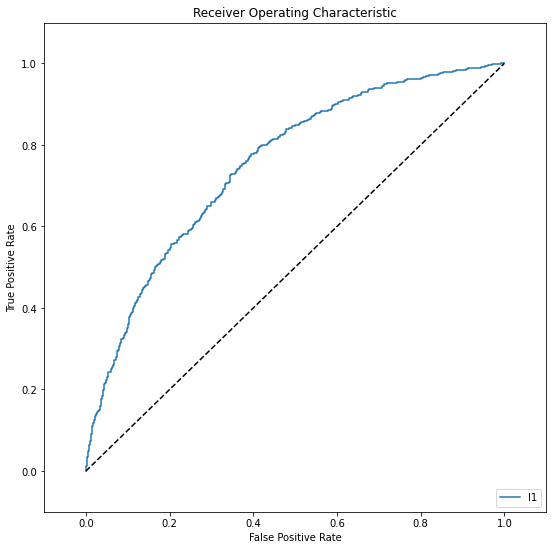

In [ ]:
# Initialize figure
fig = plt.figure(figsize=(9,9))
plt.title('Receiver Operating Characteristic')

# Plot ROC curve
plt.plot(fpr, tpr, label='l1')
plt.legend(loc='lower right')

# Diagonal 45 degree line
plt.plot([0,1],[0,1],'k--')

# Axes limits and labels
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
# AUROC
roc_auc_score(y_test, pred)

0.7522940179748114

In [ ]:
pred_class_v2 = (np.array(pred) > 0.2).astype(int)
cohen_kappa = cohen_kappa_score(y_test, pred_class_v2)
cohen_kappa

0.15546640448520088